Yelp photos clustering
=================

Classify Yelp photos using SIFT and MLP
-----------------

In [1]:
#Import the required libraries
import os
import numpy as np 
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2 as cv

from PIL import Image, ImageFilter, ImageTk
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
DeprecationWarning

from sklearn import manifold, decomposition
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

### Data preparation
We read the data

In [2]:
data = pd.read_json('yelp_photos/photos.json', lines=True)
data.head()

,photo_id,business_id,caption,label
0,Un_Og6jfhazVn7CxszkKEw,R1sIqGfKpF5f3HV3vyNsbg,Drinks! Front is beer obviously. The pink one ...,drink
1,BFE1AFOs27scnnfeBf99ZA,vdT7zlrLB2DL9pStDUs91A,,drink
2,7t-C0r1JRdoVD9FS7M-N7Q,c5GzrObEdj7eNVOdAxrppg,Stella on draft,drink
3,rLnw0d-YYZvT9kR4y7h7_Q,aQa7N5ZbPhCoKYGGB-gqfg,,drink
4,Cv5M8MDw8a5NEWvw2AQ4nw,B-s6qOFD75syhwWjp518aA,,drink


In [3]:
len(data)

200000

In [4]:
data=data.set_index('photo_id')

There are 200K images in the dataset. Now we take 1000 photos each category.

In [5]:
chunks=pd.read_json('yelp_photos/photos.json', lines=True, chunksize=200)

In [6]:
df = pd.DataFrame(columns=['photo_id', 'label'])
x = 0
for chunk in chunks:
    if(x == 0):
        if ((chunk.iloc[0].label == 'drink') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])   
            x = x + 1
    if(x == 1):    
        if ((chunk.iloc[0].label == 'food') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 2):    
        if ((chunk.iloc[0].label == 'interior') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 3):    
        if ((chunk.iloc[0].label == 'outside') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 4):    
        if ((chunk.iloc[0].label == 'menu') & len(chunk.label.value_counts()) == 1):
            df = pd.concat([df, chunk])  
            x = x + 1
    if(x == 5):
        break

In [7]:
df.head()

,photo_id,label,business_id,caption
0,Un_Og6jfhazVn7CxszkKEw,drink,R1sIqGfKpF5f3HV3vyNsbg,Drinks! Front is beer obviously. The pink one ...
1,BFE1AFOs27scnnfeBf99ZA,drink,vdT7zlrLB2DL9pStDUs91A,
2,7t-C0r1JRdoVD9FS7M-N7Q,drink,c5GzrObEdj7eNVOdAxrppg,Stella on draft
3,rLnw0d-YYZvT9kR4y7h7_Q,drink,aQa7N5ZbPhCoKYGGB-gqfg,
4,Cv5M8MDw8a5NEWvw2AQ4nw,drink,B-s6qOFD75syhwWjp518aA,


In [8]:
df.shape

(1000, 4)

In [9]:
df.label.value_counts()

drink       200
food        200
interior    200
outside     200
menu        200
Name: label, dtype: int64

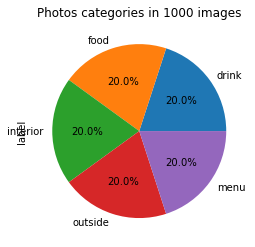

In [10]:
# Plot pie chart to check distribution
df.label.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Photos categories in 1000 images')
plt.show()

In [11]:
df['photo_id']=df['photo_id'].astype(str) + '.jpg'

In [12]:
df.head()

,photo_id,label,business_id,caption
0,Un_Og6jfhazVn7CxszkKEw.jpg,drink,R1sIqGfKpF5f3HV3vyNsbg,Drinks! Front is beer obviously. The pink one ...
1,BFE1AFOs27scnnfeBf99ZA.jpg,drink,vdT7zlrLB2DL9pStDUs91A,
2,7t-C0r1JRdoVD9FS7M-N7Q.jpg,drink,c5GzrObEdj7eNVOdAxrppg,Stella on draft
3,rLnw0d-YYZvT9kR4y7h7_Q.jpg,drink,aQa7N5ZbPhCoKYGGB-gqfg,
4,Cv5M8MDw8a5NEWvw2AQ4nw.jpg,drink,B-s6qOFD75syhwWjp518aA,


### Create a random sample from df with 800 images

In [13]:
X= df.sample(800,random_state=42)

In [14]:
X.head()

,photo_id,label,business_id,caption
80121,Y69Xj2lsIsjC2f8y8KZF9Q.jpg,interior,Dz0f97D4NhME0nTOYsvlMg,Coffee to go and delicious muffin case!
120137,hGVrjAk1IM1Mh2IazBd36w.jpg,outside,BLwCfBNuIioxYerCuNuElA,
120140,EadMMpQW3qe1ezuG2k-VnQ.jpg,outside,KBoCRksbWQKMRAIJzPDiFQ,Got a LOT of new inventory at the wash now!
120060,qdAlXgLe5H0VlhlWlbMciw.jpg,outside,RLvoJAIdTp_9apgvrvGCWw,
80011,ipYFNoq53Zv9vXgmTIYi4w.jpg,interior,H4YfD2avs9sDp-56s2E0pg,This is NOT a restaurant. Do not come here thi...


In [15]:
X.shape

(800, 4)

In [16]:
X.label.value_counts()

menu        166
food        162
drink       159
outside     157
interior    156
Name: label, dtype: int64

In [17]:
PATH = 'yelp_photos/photos/'

### Tracing the image with OpenCV.

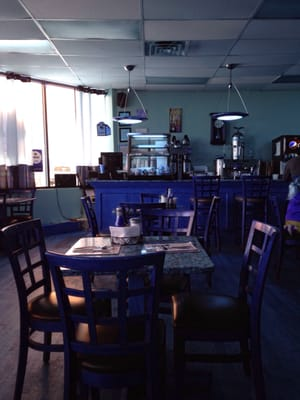

In [18]:
for i in range (0,1):
    img = cv.imread(os.path.join(PATH, X.iloc[i].photo_id))
    display(Image.fromarray(img,"RGB"))

### Resize the image 256 by 256

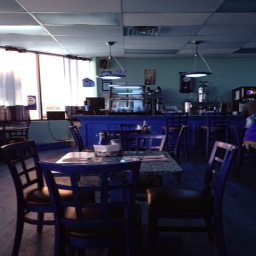

In [19]:
img_resized = cv.resize(img, (256,256))
display(Image.fromarray(img_resized,"RGB"))

### Trace the histogram of the image

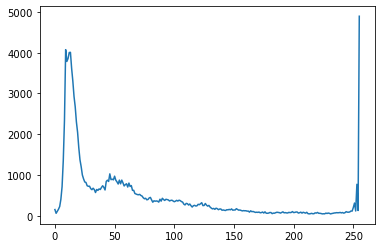

In [20]:
# plotting the histogram of an image
hist = cv.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)
plt.show()

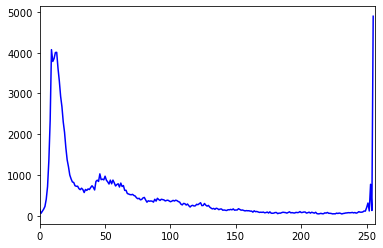

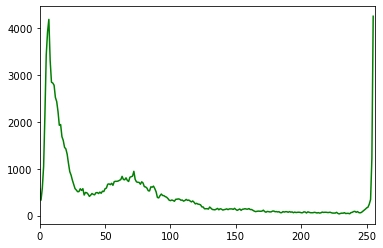

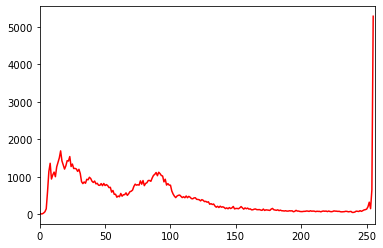

In [21]:
color=('b', 'g', 'r')
for i, col in enumerate(color):
    hist = cv.calcHist([img],[i],None,[256],[0,256])
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
    plt.show()   

###  Detect the edges

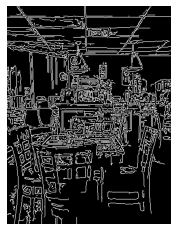

In [22]:
for i in range (0,1):
   
    img = cv.imread(os.path.join(PATH, X.iloc[i].photo_id))
  
# Calculate median intensity
median_intensity = np.median(img)

# Set thresholds to be one standard deviation above and below median intensity
lower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))
upper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))

# Apply canny edge detector
image_canny = cv.Canny(img, lower_threshold, upper_threshold)
plt.imshow(image_canny, cmap='gray'), plt.axis("off")
plt.show()

### Add contrast  to the colour Image

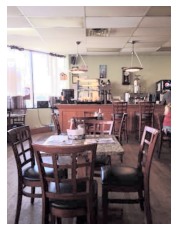

In [23]:
image_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)

# Apply histogram equalization
image_yuv[:, :, 0] = cv.equalizeHist(image_yuv[:, :, 0])

image_rgb = cv.cvtColor(image_yuv, cv.COLOR_YUV2RGB)

plt.imshow(image_rgb), plt.axis("off")
plt.show()

### Harris Corner Detector

In [24]:
image_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
image_gray = np.float32(image_gray)
block_size = 2
aperture = 29
free_parameter = 0.04

detector_responses = cv.cornerHarris(image_gray, block_size, aperture, free_parameter)

# Large corner markers
detector_responses = cv.dilate(detector_responses, None)

# Only keep detector responses greater than threshold, mark as white
threshold = 0.02
img[detector_responses > threshold * detector_responses.max()] = [255,255,255]

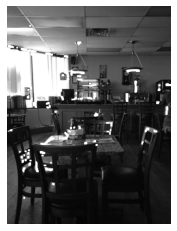

In [25]:
# Convert to grayscale
image_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Show image
plt.imshow(image_gray, cmap='gray'), plt.axis("off")
plt.show()

### Extract key points and SIFT descriptors

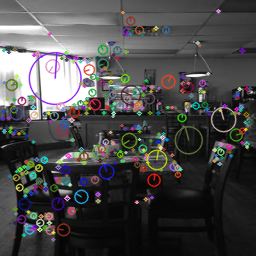

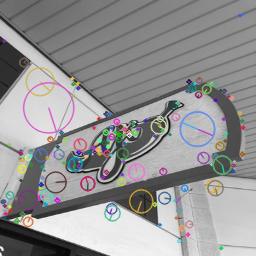

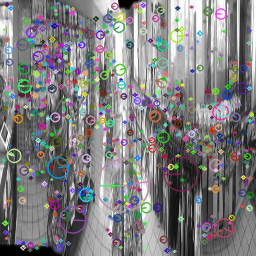

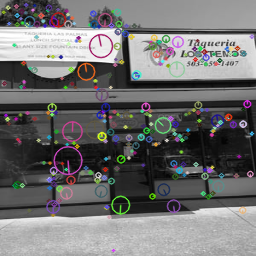

In [26]:
for i in range (0,4):
   
    img = cv.imread(os.path.join(PATH, X.iloc[i].photo_id))
    img= cv.resize(img, (256,256))
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
   
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray,None)
    
    
    img=cv.drawKeypoints(gray,kp,img)
    img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    display(Image.fromarray(img,"RGB"))

### Add  Gaussian Blur to reduce the numbers of descriptors

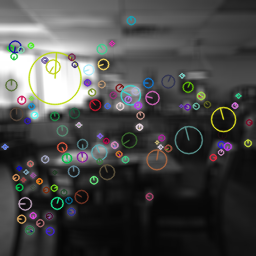

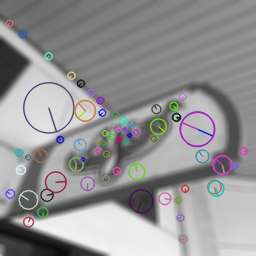

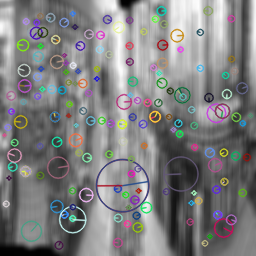

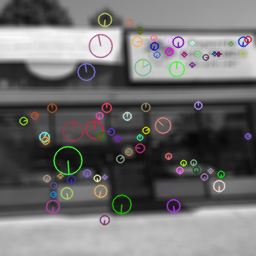

In [27]:
for i in range (0,4):
   
    img = cv.imread(os.path.join(PATH, X.iloc[i].photo_id))
    img = cv.resize(img, (256,256))
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
        # Gaussian Blur
    gray = Image.fromarray(gray).convert('L')
    gray = gray.filter(ImageFilter.BoxBlur(3))
    gray = np.array(gray)
    
   
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray,None)    
    
    img=cv.drawKeypoints(gray,kp,img)
    img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    display(Image.fromarray(img,"RGB"))

In [28]:
X = X.reset_index(drop=True)
X.head()

,photo_id,label,business_id,caption
0,Y69Xj2lsIsjC2f8y8KZF9Q.jpg,interior,Dz0f97D4NhME0nTOYsvlMg,Coffee to go and delicious muffin case!
1,hGVrjAk1IM1Mh2IazBd36w.jpg,outside,BLwCfBNuIioxYerCuNuElA,
2,EadMMpQW3qe1ezuG2k-VnQ.jpg,outside,KBoCRksbWQKMRAIJzPDiFQ,Got a LOT of new inventory at the wash now!
3,qdAlXgLe5H0VlhlWlbMciw.jpg,outside,RLvoJAIdTp_9apgvrvGCWw,
4,ipYFNoq53Zv9vXgmTIYi4w.jpg,interior,H4YfD2avs9sDp-56s2E0pg,This is NOT a restaurant. Do not come here thi...


In [29]:
X.isnull().sum()

photo_id       0
label          0
business_id    0
caption        0
dtype: int64

Now we drop the 'business_id' and 'caption' from the dataset X.

In [30]:
X=X[['photo_id', 'label']]
X.head()

,photo_id,label
0,Y69Xj2lsIsjC2f8y8KZF9Q.jpg,interior
1,hGVrjAk1IM1Mh2IazBd36w.jpg,outside
2,EadMMpQW3qe1ezuG2k-VnQ.jpg,outside
3,qdAlXgLe5H0VlhlWlbMciw.jpg,outside
4,ipYFNoq53Zv9vXgmTIYi4w.jpg,interior


### Image of the interior

In [31]:
X1=X[X['label'] == 'interior']

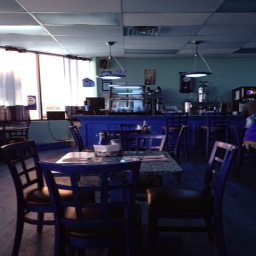

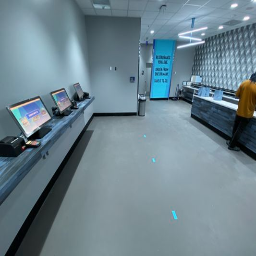

In [32]:
for i in range (0,2):
    img = cv.imread(os.path.join(PATH, X1.iloc[i].photo_id))
    img=cv.resize(img, (256,256))
    display(Image.fromarray(img,"RGB"))

### Image of the exterior

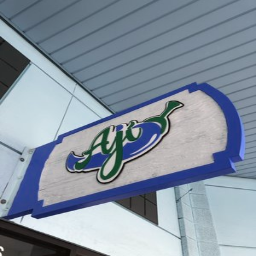

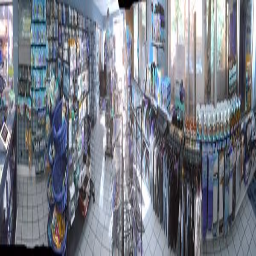

In [33]:
X2=X[X['label'] == "outside"]

for i in range (0,2):
    img = cv.imread(os.path.join(PATH, X2.iloc[i].photo_id))
    img=cv.resize(img, (256,256))
    display(Image.fromarray(img,"RGB"))

### Image of the menu

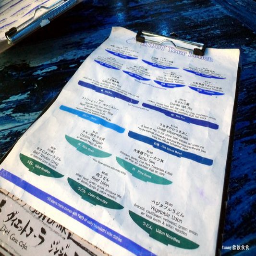

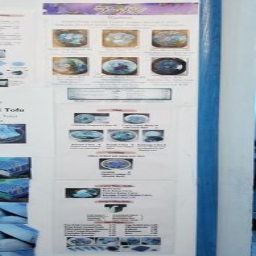

In [34]:
X3=X[X['label'] == 'menu']

for i in range (0,2):
    img = cv.imread(os.path.join(PATH, X3.iloc[i].photo_id))
    img=cv.resize(img, (256,256))
    display(Image.fromarray(img,"RGB"))

### Image of the food

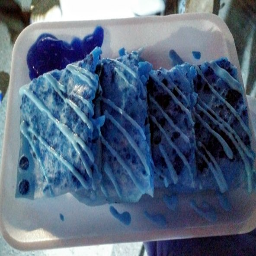

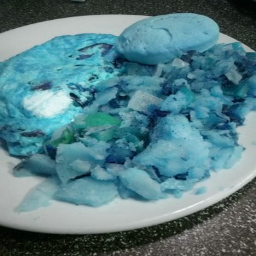

In [35]:
X4=X[X['label'] == 'food']

for i in range (0,2):
    img = cv.imread(os.path.join(PATH, X4.iloc[i].photo_id))
    img=cv.resize(img, (256,256))
    display(Image.fromarray(img,"RGB"))

### Image of drinks

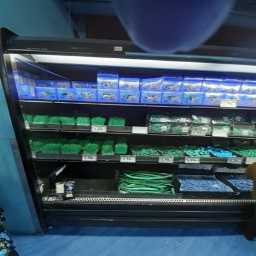

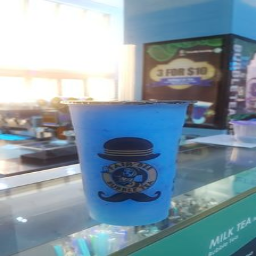

In [36]:
X5=X[X['label'] == 'drink']  
for i in range (0,2):
    img = cv.imread(os.path.join(PATH, X5.iloc[i].photo_id))
    img=cv.resize(img, (256,256))
    display(Image.fromarray(img,"RGB"))  

### Ceation of descriptors for each image

In [37]:
descriptors = []

for i, val in X[0:500].iterrows():
    # Read image
    img = cv.imread(os.path.join(PATH, X.iloc[i].photo_id))
    img=cv.resize(img, (256,256))
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # Gaussian Blur
    gray = Image.fromarray(gray).convert('L')
    gray = gray.filter(ImageFilter.BoxBlur(0))
    gray = np.array(gray)

    # Create descriptors
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray,None)
    try: 
        descriptors.append(desc[:])
    except Exception: 
        print('Osef')

In [38]:
descriptors[0].shape

(431, 128)

Numbers of descriptors

In [39]:
descriptors_vstacked = np.vstack(descriptors)
descriptors_vstacked.shape

(234043, 128)

### Creation of clusters of descriptors using K Means

In [40]:
k = int(round(np.sqrt(len(descriptors_vstacked)),0))
print('Estimated number of clusters:', k)

Estimated number of clusters: 484


In [41]:
kmeans = MiniBatchKMeans(n_clusters=k, init_size=2*k, random_state=42)
kmeans.fit(descriptors_vstacked)

MiniBatchKMeans(init_size=968, n_clusters=484, random_state=42)

### Creation of features of images

In [42]:
# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("error  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(descriptors) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

img_features = np.asarray(hist_vectors)

0
100
200
300
400


### Reduce the  dimension using PCA

In [43]:
from sklearn import manifold, decomposition

print("Dimensions before PCA :", img_features.shape)
pca = decomposition.PCA(n_components=0.98)
feat_pca= pca.fit_transform(img_features)
print("Dimensions after PCA :", feat_pca.shape)

Dimensions before PCA : (500, 484)
Dimensions after PCA : (500, 287)


### TSNE for visualization

In [44]:
tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(data=X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = X["label"]
print(df_tsne.shape)

(500, 3)


In [45]:
df_tsne.head()

,tsne1,tsne2,class
0,4.302105,2.181557,interior
1,-5.911932,2.491590,outside
2,-0.554961,-1.517978,outside
3,-4.814548,-0.049503,outside
4,-1.096002,1.068778,interior


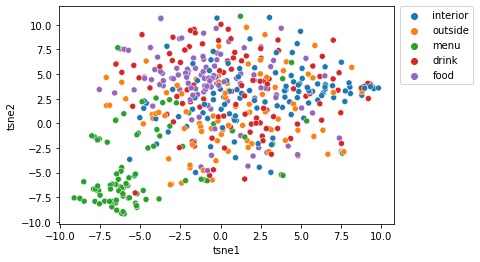

In [46]:
sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

#### Creation of clusters with respect to the T-SNE

In [47]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=5, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

In [48]:
score = silhouette_score(X_tsne, cls.labels_)  
score

0.38351902

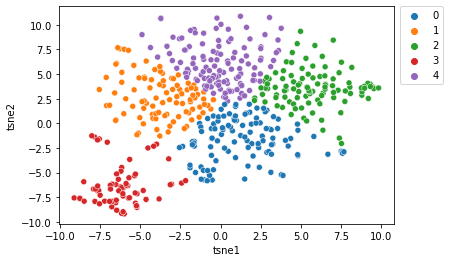

In [49]:
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", data=df_tsne, palette=sns.color_palette('tab10', n_colors=5))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [50]:
df_tsne.head()

,tsne1,tsne2,class,cluster
0,4.302105,2.181557,interior,2
1,-5.911932,2.491590,outside,1
2,-0.554961,-1.517978,outside,0
3,-4.814548,-0.049503,outside,1
4,-1.096002,1.068778,interior,1


In [51]:
Z=pd.concat([X[:500], df_tsne['cluster']],axis=1)
Z.head()

,photo_id,label,cluster
0,Y69Xj2lsIsjC2f8y8KZF9Q.jpg,interior,2
1,hGVrjAk1IM1Mh2IazBd36w.jpg,outside,1
2,EadMMpQW3qe1ezuG2k-VnQ.jpg,outside,0
3,qdAlXgLe5H0VlhlWlbMciw.jpg,outside,1
4,ipYFNoq53Zv9vXgmTIYi4w.jpg,interior,1


In [52]:
Z.shape

(500, 3)

In [53]:
labels = Z["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.15057070434417702


### Bad ARI score.

In [54]:
Z.label.value_counts()

interior    113
food        105
drink       103
menu         92
outside      87
Name: label, dtype: int64

### Use Label Encoder to change the label into numbers

In [55]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le = le.fit_transform(labels)

In [56]:
d = {'label': labels, 'encoded': le}
dg = pd.DataFrame(data=d)

In [57]:
dg1 = labels.astype('category')
dg1.cat.categories.get_loc('food')

1

In [58]:
dg1.cat.categories.get_loc('interior')

2

In [59]:
dg1.cat.categories.get_loc('drink')

0

In [60]:
dg1.cat.categories.get_loc('menu')

3

In [61]:
dg1.cat.categories.get_loc('outside')

4

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix

cm = confusion_matrix(le, df_tsne['cluster'])
print(cm)

[[32 16 22  1 32]
 [13 31 10  0 51]
 [19 14 52  2 26]
 [11 15  3 62  1]
 [36 18 15  4 14]]


In [63]:
y_true=le
y_pred=df_tsne['cluster']

In [64]:
accuracy_score(y_true, y_pred)

0.382

In [65]:
cm_df = pd.DataFrame(cm,index = ['outside','interior', 'menu','food','drink'], 
                     columns = ['outside','interior', 'menu','food','drink'])

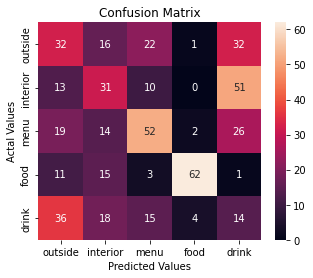

In [66]:
# Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Let us try use the Multi-Layer Perceptron  network

In [67]:
def createHist(imgName):
    #Extract desc
    img = cv.imread(os.path.join(PATH, imgName))
    img=cv.resize(img, (256,256))
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)   
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray,None)
    
    #Build hist
    hist = build_histogram(kmeans, desc, 0)
    
    return hist

In [68]:
X = img_features
y = le

In [69]:
mlp = MLPClassifier(activation='relu', max_iter=10000)
mlp.fit(X, y)

MLPClassifier(max_iter=10000)

In [70]:
def mlpPredict(imn, mlp):
    x = createHist(imn)
    predicted = mlp.predict_proba([x])
    return result.loc[result.id == np.argmax(predicted)].label.values[0]    

In [71]:
result = [(0, 'drink'),(1, 'food'),(2, 'interior'), (3, 'menu'), (4, 'outside')]
result = pd.DataFrame(columns=['id', 'label'], data=result)

### Let us choose an image & use our MLP model to predict what label it belongs.

In [72]:
imn='___nkxLEUotLL8xuKPy6gA.jpg'
predicted_label=mlpPredict(imn, mlp)
img = cv.imread(os.path.join(PATH, imn))
img=cv.resize(img, (256,256))

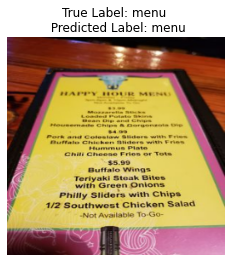

In [73]:
import cv2
import matplotlib.pyplot as plt

plt.title(f"True Label: {data.at['___nkxLEUotLL8xuKPy6gA', 'label']} \n Predicted Label: {predicted_label}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Hence it is correctly predicted.